In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./Sarcasm_on_Reddit/train-balanced-sarcasm.csv')
df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Data preprocessing

In [4]:
df.dropna(subset=['comment'], inplace=True)
df['comment'] = df['comment'].str.lower()
df['comment'] = df['comment'].str.replace('[^\w\s]','')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


- Label distribution

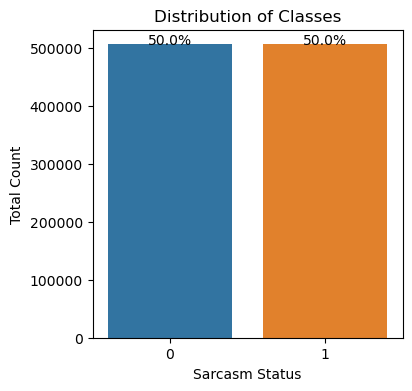

In [6]:
# Plotting the distribution of classes
plt.figure(figsize=(4,4))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format((height/total)*100), ha="center") 
plt.show()

The graph above ensures that the dataset is balanced as the proportion of the sarcastic and non-sarcastic comments are same (50%).

- Distribution of comment lengths

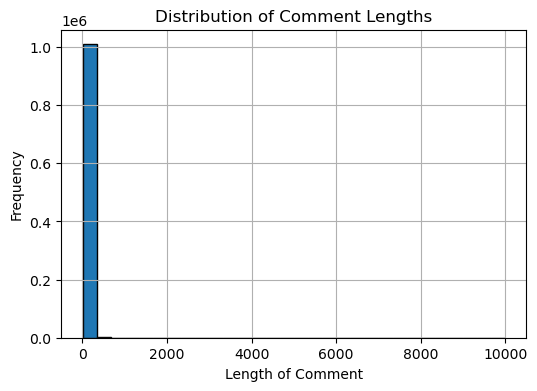

In [7]:
# Plotting the distribution of comment lengths
df['comment_length'] = df['comment'].str.len()

plt.figure(figsize=(6, 4))
df['comment_length'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The dataset is long tail distributed, so apply log transformations.

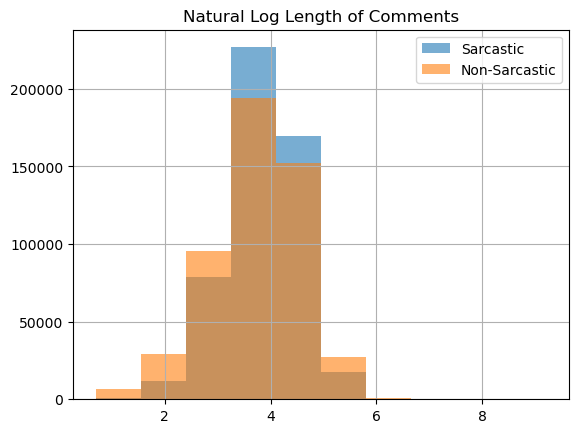

In [8]:
df['log_comment'] = df['comment'].apply(lambda text: np.log1p(len(text)))
df[df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic')
df[df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()


- Wordcloud of Scarstic comments:

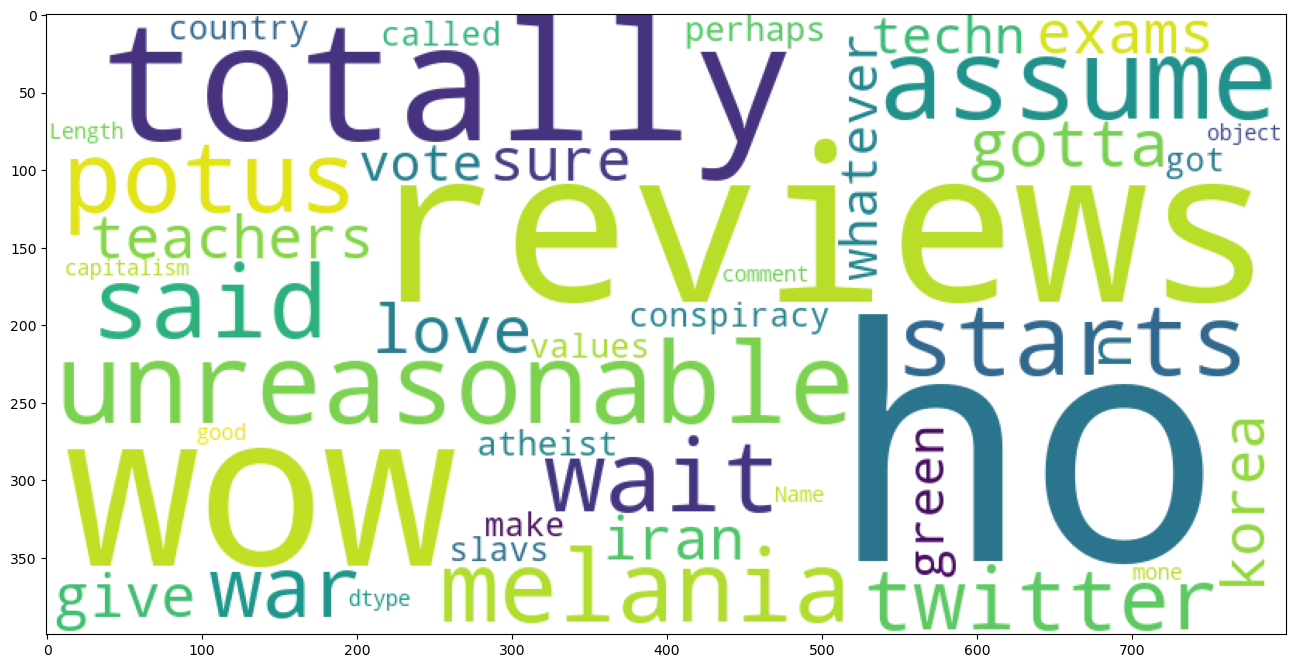

In [9]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', #max_words = 200, 
                      #max_font_size = 100, random_state = 17, 
                      width=800, height=400)

plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
#plt.grid(b= False)
plt.imshow(wordcloud)

- Top popular subreddits & Sarcastic comments

In [10]:
# Getting the top 10 popular subreddits
df['subreddit'].value_counts()[:10]

subreddit
AskReddit          65674
politics           39493
worldnews          26375
leagueoflegends    21034
pcmasterrace       18987
funny              17939
news               16891
pics               16152
todayilearned      14159
nfl                14149
Name: count, dtype: int64

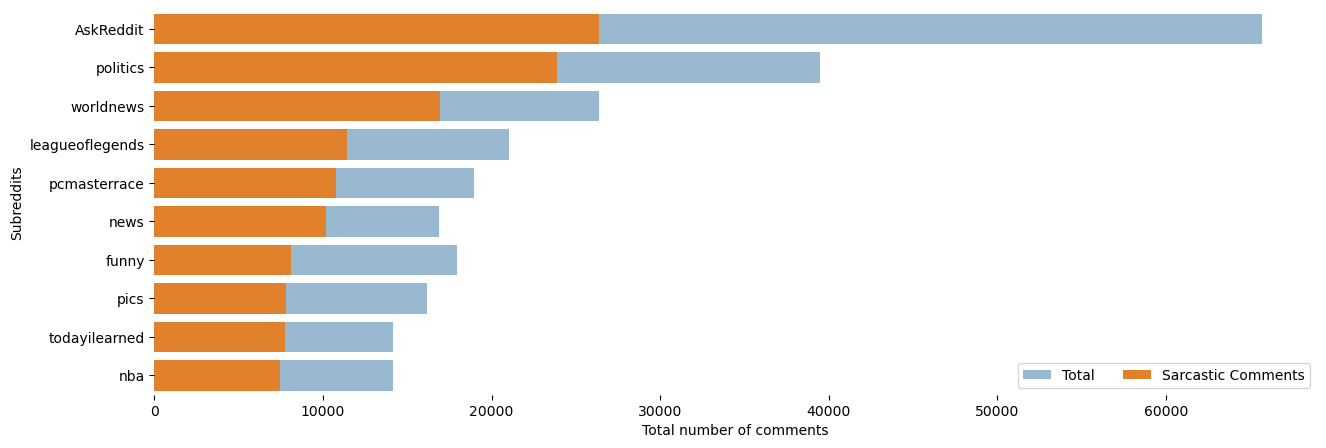

In [11]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace', 'news', 'funny', 'pics', 'todayilearned', 'nba']
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

# Calculating the count of Sarcastic and Natural comments for the top 10 subreddits 
for i in range(len(top_reddits)):
    temp = df.loc[df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

# Plotting the distribution of comments in the top 10 subreddits
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="#1f77b4", alpha=0.5)
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="#ff7f0e", alpha=1)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

- Top authors by comment count

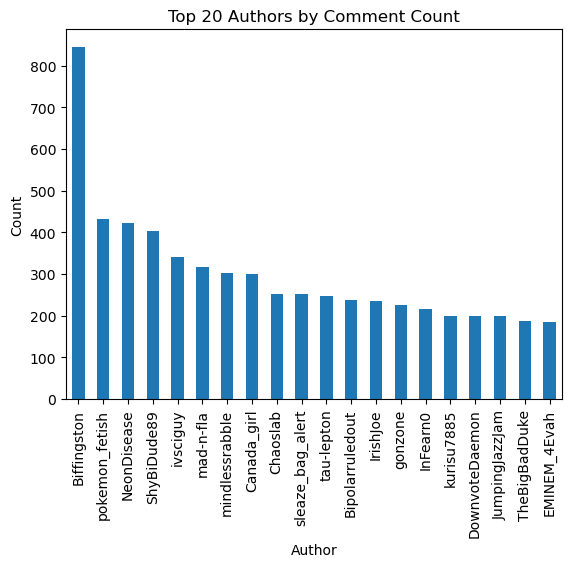

In [12]:
df['author'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Authors by Comment Count')
plt.xlabel('Author')
plt.ylabel('Count')
plt.show()

- Score distribution

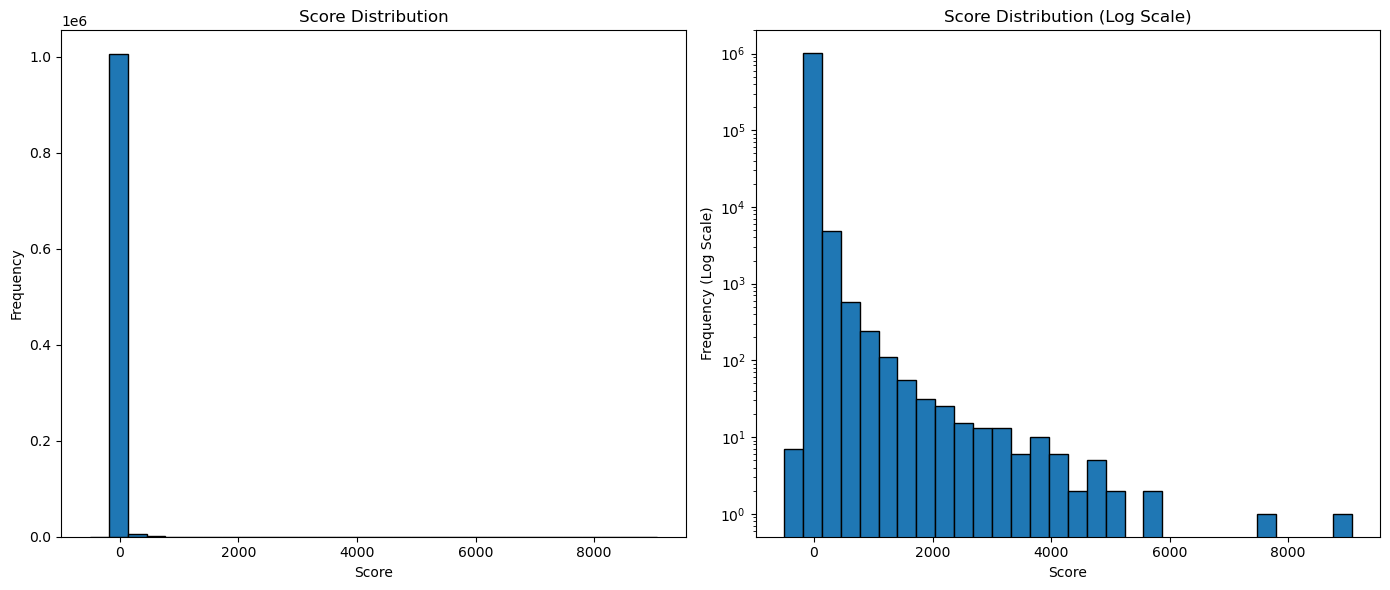

In [13]:
plt.figure(figsize=(14, 6))

# Score distribution
plt.subplot(1, 2, 1)
df['score'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Score distribution (log scale)
plt.subplot(1, 2, 2)
df['score'].plot(kind='hist', bins=30, edgecolor='black', logy=True)
plt.title('Score Distribution (Log Scale)')
plt.xlabel('Score')
plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

- relationship between labels and scores

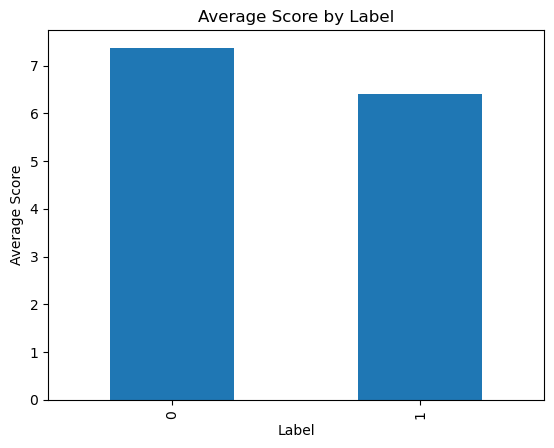

In [14]:
df.groupby('label')['score'].mean().plot(kind='bar')
plt.title('Average Score by Label')
plt.xlabel('Label')
plt.ylabel('Average Score')
plt.show()

Generally, non-sarcastic comments have higher scores than sarcastic comments.

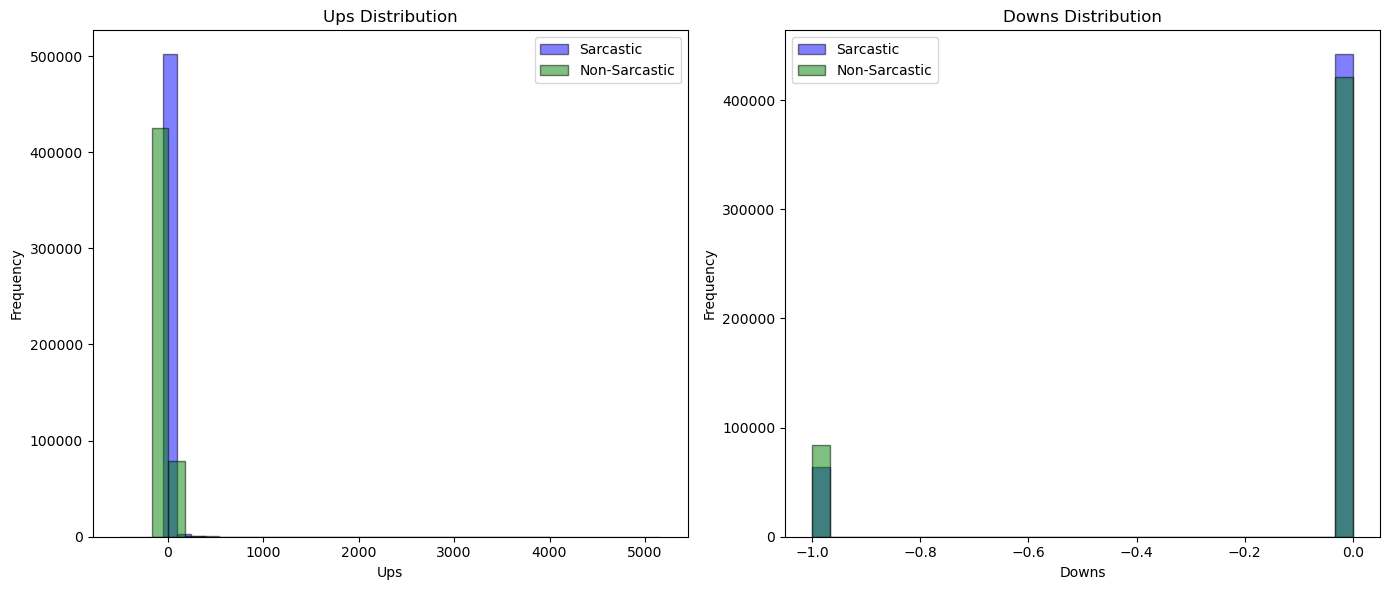

In [15]:
label_1 = df[df['label'] == 1]
label_0 = df[df['label'] == 0]


plt.figure(figsize=(14, 6))

# Ups Distribution
plt.subplot(1, 2, 1)
label_1['ups'].plot(kind='hist', bins=30, alpha=0.5, color='blue', edgecolor='black', label='Sarcastic')
label_0['ups'].plot(kind='hist', bins=30, alpha=0.5, color='green', edgecolor='black', label='Non-Sarcastic')
plt.title('Ups Distribution')
plt.xlabel('Ups')
plt.ylabel('Frequency')
plt.legend()

# Downs Distribution
plt.subplot(1, 2, 2)
label_1['downs'].plot(kind='hist', bins=30, alpha=0.5, color='blue', edgecolor='black', label='Sarcastic')
label_0['downs'].plot(kind='hist', bins=30, alpha=0.5, color='green', edgecolor='black', label='Non-Sarcastic')
plt.title('Downs Distribution')
plt.xlabel('Downs')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()